<a href="https://colab.research.google.com/github/ABD-01/Siamese-Triplet/blob/master/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.cuda.is_available()

True

In [3]:
import sklearn
from sklearn import datasets

In [4]:
lfw_pairs = datasets.fetch_lfw_pairs(
    subset='train',
    data_home="/content/drive/MyDrive/Colab Notebooks/lfw",
    funneled=False,
    resize=1,
    color=True,
    # download_if_missing=True
    )
# ref : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_pairs.html

In [9]:
lfw_pairs.keys()

dict_keys(['data', 'pairs', 'target', 'target_names', 'DESCR'])

In [6]:
pairDevTrain = open("/content/drive/MyDrive/Colab Notebooks/lfw/lfw_home/pairsDevTrain.txt").readlines()[1:]

Nicolas_Lapentti	1	Paula_Dobriansky	1

Different persons


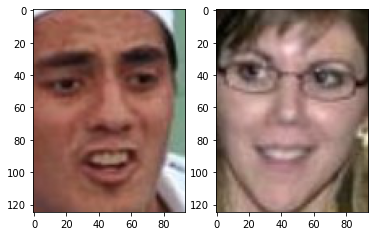

In [8]:
index = 2109
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [7]:
lfw_people = datasets.fetch_lfw_people(
    data_home="/content/drive/MyDrive/Colab Notebooks/LFW",
    min_faces_per_person=2,
    resize=1,
    color=True,
    download_if_missing=True
)

In [10]:
lfw_people.data.shape

(9164, 35250)

In [11]:
lfw_people.images.shape

(9164, 125, 94, 3)

In [ ]:
np.moveaxis(lfw_people.images, -1,-3).shape

In [ ]:
lfw_people.keys()

In [ ]:
lfw_people.target[46]# .shape

In [ ]:
plt.imshow(lfw_people.images[5] / 255)
lfw_people.target_names[lfw_people.target[5]]

In [ ]:
randomstate = np.random.RandomState(seed=None)

In [ ]:
no_of_classes = len(lfw_people.target_names)

In [ ]:
pos_class = randomstate.choice(no_of_classes)
neg_class = randomstate.choice(no_of_classes)
while pos_class == neg_class:
    neg_class = randomstate.choice(classes_per_batch)
pos_class, neg_class

In [ ]:
pos_name = lfw_people.target_names[pos_class]
neg_name = lfw_people.target_names[neg_class]
pos_name, neg_name

In [ ]:
pos_imgs = lfw_people.images[lfw_people.target == pos_class]
neg_imgs = lfw_people.images[lfw_people.target == neg_class]
pos_imgs.shape[0], neg_imgs.shape[0]

In [ ]:
if pos_imgs.shape[0] == 2:
    ianc, ipos = 0,1
else:
    ianc = randomstate.randint(0, pos_imgs.shape[0])
    ipos = randomstate.randint(0, pos_imgs.shape[0])
    while ianc == ipos:
        ipos = randomstate.randint(0, len(face_classes[pos_class]))

In [ ]:
ineg = randomstate.randint(0, neg_imgs.shape[0])

In [ ]:
ianc

In [ ]:

# Ref : https://github.com/tamerthamoqa/facenet-pytorch-vggface2/blob/master/datasets/TripletLossDataset.py#L76-L136

In [ ]:
_,axxar = plt.subplots(1,3)
axxar[0].imshow(pos_imgs[ianc] / 255)
axxar[1].imshow(pos_imgs[ipos] / 255)
axxar[2].imshow(neg_imgs[ineg] / 255)
print(f'Pos_class : {pos_name}, Neg_class : {neg_class}')

In [ ]:
lfw_people.target_names[928]

In [ ]:
triplets = []

In [8]:
def get_random_triplets(no_classes:int, images, target, no_triplets:int):
    # Ref : https://github.com/tamerthamoqa/facenet-pytorch-vggface2/blob/master/datasets/TripletLossDataset.py#L76-L136
    randomstate = np.random.RandomState(seed=None)
    # no_class = len(lfw_people.target_names)
    triplets = []
    class_pairs = []

    ###
    # _,axxar = plt.subplots(no_triplets,3, figsize=(7,5))
    # plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    # # ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
    ###

    # progress_bar = tqdm(range(no_triplets), desc='fetching triplets')
    for progress in range(no_triplets):

        pos_class = randomstate.choice(no_classes)
        neg_class = randomstate.choice(no_classes)
        while pos_class == neg_class:
            neg_class = randomstate.choice(no_classes)

        # pos_name = lfw_people.target_names[pos_class]
        # neg_name = lfw_people.target_names[neg_class]

        pos_imgs = images[target == pos_class]
        neg_imgs = images[target == neg_class]

        if pos_imgs.shape[0] == 2:
            ianc, ipos = 0,1
        else:
            ianc = randomstate.randint(0, pos_imgs.shape[0])
            ipos = randomstate.randint(0, pos_imgs.shape[0])
            while ianc == ipos:
                ipos = randomstate.randint(0, pos_imgs.shape[0])
        ineg = randomstate.randint(0, neg_imgs.shape[0])

        ####
        # axxar[progress][0].imshow(pos_imgs[ianc] / 255)
        # axxar[progress][0].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][1].imshow(pos_imgs[ipos] / 255)
        # axxar[progress][1].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][2].imshow(neg_imgs[ineg] / 255)
        # axxar[progress][2].set_title(lfw_people.target_names[neg_class])
        ####

        triplets.append(
            torch.stack([
                torch.from_numpy(pos_imgs[ianc] / 255), 
                torch.from_numpy(pos_imgs[ipos] / 255), 
                torch.from_numpy(neg_imgs[ineg] / 255)
            ]))
        class_pairs.append((pos_class, neg_class))

    return torch.stack(triplets) , class_pairs

fetching triplets: 100%|██████████| 5/5 [00:00<00:00, 187.59it/s]


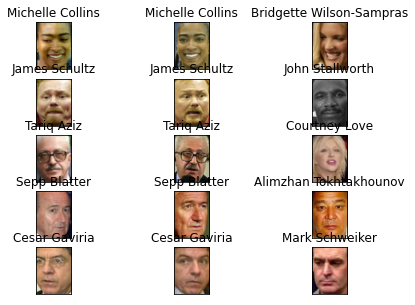

In [ ]:
triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names), images=lfw_people.images, target=lfw_people.target, no_triplets=5)

Text(0.5, 1.0, 'hello')

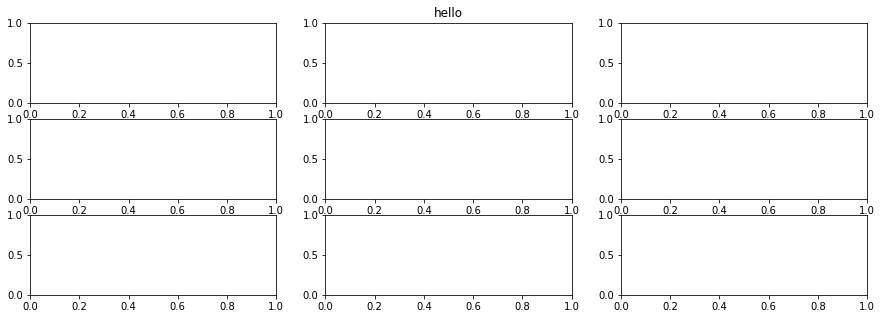

In [ ]:
_,axxar = plt.subplots(3,3, figsize = (15,5))
axxar[0,1].set_title('hello')

In [ ]:
triplets.shape

torch.Size([3, 3, 125, 94, 3])

In [ ]:
triplets.shape

torch.Size([3, 3, 125, 94, 3])

# Model

In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7,5))),
                            ('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5))),
                            # ('norm', nn.BatchNorm2d(32)),
                            ('relu', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2

        self.convnet2 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            # ('norm', nn.BatchNorm2d(64)),
                            ('relu', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.convnet3 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)),
                            # ('norm', nn.BatchNorm2d(128)),
                            ('relu', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.FCs      = nn.Sequential(OrderedDict([
                            ('FC1', nn.Linear(in_features=7680, out_features=2048)),
                            ('relu1', nn.ReLU(inplace=True)),
                            ('FC2', nn.Linear(in_features=2048, out_features=512)),
                            ('relu2', nn.ReLU(inplace=True)),
                            ('FC3', nn.Linear(in_features=512, out_features=128)),
                            ('relu3', nn.ReLU(inplace=True)),
        ]))

        # self.out      = nn.Linear(in_features=128, out_features=2)

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')  # He-initialization
                # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

    def semi_forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        # x = x.view(-1, 10*6*128)
        x = x.reshape(-1, 10*6*128)
        x = self.FCs(x)
        return x

    def forward(self,triplet):
        triplet = triplet.movedim(-1, -3)
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [16]:
x = torch.rand(10, 3, 125, 94, 3)
print(x.shape)
x = x.movedim(-1, -3)
print(x.shape)
print(x[:,0,...].shape)
x = model.convnet1(x[:,0,...])
print(x.shape)
x = model.convnet2(x)
print(x.shape)
x = model.convnet3(x)
print(x.shape)
x = x.view(-1, 10*6*128)
print(x.shape)
x = model.FCs(x)
print(x.shape)
print()
x = torch.rand(10, 3, 125, 94, 3)
# x = x.movedim(-1, -3)
x = model(x)
print(x[0].shape)

torch.Size([10, 3, 125, 94, 3])
torch.Size([10, 3, 3, 125, 94])
torch.Size([10, 3, 125, 94])
torch.Size([10, 32, 57, 42])
torch.Size([10, 64, 26, 18])
torch.Size([10, 128, 10, 6])
torch.Size([10, 7680])
torch.Size([10, 128])

torch.Size([10, 128])


In [13]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(7, 5), stride=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FCs): Sequential(
    (FC1): Linear(in_features=7680, out_features=2048, bias=True)
    (relu1): ReLU(inplace=True)
    (FC2): Linear(in_features=2048, out_features=5

In [ ]:
lfw_pairs.pairs[:1100].shape

(1100, 2, 125, 94, 3)

In [ ]:
lfw_pairs.pairs[1100:, 0].shape

(1100, 125, 94, 3)

In [16]:
def triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [17]:
model = Model().cuda()
learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lossfn = nn.TripletMarginLoss(margin=1, reduction='mean')

In [18]:
lfw_people.images.shape

(9164, 125, 94, 3)

In [19]:
cost = []

epochs = 100
for epoch in range(epochs):

    triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names),
                                                images=lfw_people.images, 
                                                target=lfw_people.target, no_triplets=500)

    apn = model(triplets.cuda())
    # apn = model(triplets)

    optimizer.zero_grad()
    # loss = triplet_loss(*apn)
    loss = lossfn(*apn)
    cost.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}\n')


Epoch:[1/100] , Cost : 0.9606595039367676

Epoch:[2/100] , Cost : 2.6002912521362305

Epoch:[3/100] , Cost : 0.8585166931152344

Epoch:[4/100] , Cost : 0.9841393232345581

Epoch:[5/100] , Cost : 0.8894128799438477

Epoch:[6/100] , Cost : 0.9722683429718018

Epoch:[7/100] , Cost : 0.8615855574607849

Epoch:[8/100] , Cost : 0.8748641610145569

Epoch:[9/100] , Cost : 0.8212466835975647

Epoch:[10/100] , Cost : 0.8187441825866699

Epoch:[11/100] , Cost : 0.8098776340484619

Epoch:[12/100] , Cost : 0.7996058464050293

Epoch:[13/100] , Cost : 0.8951345086097717

Epoch:[14/100] , Cost : 0.7900758981704712

Epoch:[15/100] , Cost : 0.7426540851593018

Epoch:[16/100] , Cost : 0.7765974402427673

Epoch:[17/100] , Cost : 0.7451980113983154

Epoch:[18/100] , Cost : 0.6936548352241516

Epoch:[19/100] , Cost : 0.6541237235069275

Epoch:[20/100] , Cost : 0.7105103731155396

Epoch:[21/100] , Cost : 0.6882278919219971

Epoch:[22/100] , Cost : 0.6676141023635864

Epoch:[23/100] , Cost : 0.69346684217453


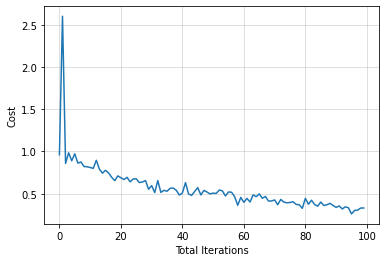

In [20]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs), cost)
plt.grid(alpha=0.5)
plt.show()

In [21]:
apn[0].sum()

tensor(8755.3477, device='cuda:0', grad_fn=<SumBackward0>)

In [22]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
p

tensor([17.8137,  2.4497,  7.4545, 13.6510,  7.9849, 17.5037,  6.0425,  3.0965,
         4.6309,  5.8813,  5.8996,  4.2669,  1.3866,  3.7878,  2.3012,  5.3768,
         3.7143, 18.6473,  0.8558,  1.2014,  2.7019,  2.1081,  1.9932,  8.8483,
        26.7110, 13.4540, 14.8404, 11.6505,  5.5245,  2.1816,  2.4459,  7.7517,
         5.1010,  0.8481,  3.1081,  1.8339,  6.5496,  5.4717,  3.5248,  8.4506,
         2.0604,  5.9194,  2.7019, 11.1629, 19.3943, 15.1151,  2.3012,  1.5253,
        39.4579,  5.2704, 52.5224, 10.9623, 12.1555,  4.2533, 15.6024, 10.7598,
         7.4114,  4.2699,  9.3556, 10.0538,  3.5013,  5.3093,  4.4484,  7.8250,
         4.5962,  5.9880,  3.2207,  7.8653,  9.4937,  1.8615,  2.5704,  0.8354,
         1.1982,  2.2302,  3.6235,  2.1367,  1.5267, 12.8056, 17.5037, 18.5669,
         0.2782,  0.9094, 11.0509,  5.5783, 13.8779,  0.6103,  3.2550,  1.5164,
         4.6873,  9.0042,  6.5581, 23.2356,  1.7412, 15.2659,  4.7264,  7.0474,
         2.5387,  2.0153,  0.3949,  1.75

In [23]:
n = (apn[0] - apn[2]).pow(2).sum(-1)
n

tensor([ 24.9656,  13.8318,  30.7319,  57.4944,  60.8321,  18.5237,  10.7195,
          3.4568,   9.1677,   4.2079,  32.6162,   2.2027,  30.8225,  67.0487,
          6.4107,  10.4134,  40.7320,  20.2275,  39.6356,   9.8785,  10.0451,
         21.5944,  24.7486,   2.8068,  56.5221,   6.3264,   1.2100,  30.4073,
         65.0040,  19.4668,   9.3908,  12.1060,   7.0006,  14.0425,   8.1457,
         60.6080,  30.2844,  15.2357,  13.5149,  26.7042,  33.4360,   1.5181,
         19.7534,  13.4454,  36.9891,   2.7198,  20.8643,  15.9785,  25.7069,
         11.2945,  27.2938,  12.8427,  23.4057,  41.6055,  20.7102,  40.7567,
          8.3969,  49.5359,  50.9782,   5.0497,  25.9423,  36.5636,  64.7726,
         11.3480,  19.7817,  18.9200,  27.2846,   8.5525,  32.3785,   6.2868,
          5.0043,  28.7432,  19.3367,  24.9714,   8.6964,  18.3273,   6.9829,
         12.1333,  45.5183,  26.1259,  26.0972,   9.2422,  43.4753,  10.6898,
         11.2288,  22.9938,  24.5335,   7.6962,  12.5614,  34.69

In [28]:
p.max() , p.mean() , n.max(), n.mean()

(tensor(56.0358, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(6.4649, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(116.8961, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(21.4141, device='cuda:0', grad_fn=<MeanBackward0>))

In [27]:
(p-n).mean()

tensor(-14.9492, device='cuda:0', grad_fn=<MeanBackward0>)

In [40]:
(F.relu(p-n + 1)).mean()

tensor(0.6459, device='cuda:0', grad_fn=<MeanBackward0>)

In [41]:
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [29]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)

In [42]:
loader = torch.utils.data.DataLoader(lfw_pairs.pairs, batch_size=100)

In [43]:
len(loader)

22

In [44]:
sample = next(iter(loader))
sample.shape

torch.Size([100, 2, 125, 94, 3])

In [47]:
pred = []

In [48]:
for sample in loader:
    test1 = sample[:,0,...].cuda() /255
    test2 = sample[:,1,...].cuda() /255
    enc1 = model.semi_forward(test1.movedim(-1,-3))
    enc2 = model.semi_forward(test2.movedim(-1,-3))
    d = dist(enc1,enc2)
    pred.append(d.cpu().detach().numpy())

In [54]:
pre = [torch.tensor(a) for a in pred]

In [55]:
PRED = torch.cat(pre)

In [56]:
PRED.shape

torch.Size([2200])

In [58]:
same_pred = PRED <= 17

In [62]:
same_pred[:1100].sum()

tensor(1051)

In [67]:
same_pred[:1100].sum() / 1100 , "% age accuracy on Same person"

(tensor(0.9555), '% age accuracy on Same person')

In [63]:
same_pred[1100:].sum()

tensor(654)

In [69]:
same_pred[1100:].sum() / 1100 , "% age error on Different person"

(tensor(0.5945), '% age error on Different person')

In [36]:
index = 125
test1 = torch.from_numpy(lfw_pairs.pairs[index][0]).cuda() /255
test2 = torch.from_numpy(lfw_pairs.pairs[index][1]).cuda() /255
enc1 = model.semi_forward(test1.movedim(-1,-3).unsqueeze(0))
enc2 = model.semi_forward(test2.movedim(-1,-3).unsqueeze(0))
d = dist(enc1,enc2)
print(d)
print('Different Person') if d > 17 else print('Same Person')

tensor([2.1782], device='cuda:0', grad_fn=<SumBackward1>)
Same Person


Bill_Belichick	1	2

Same person


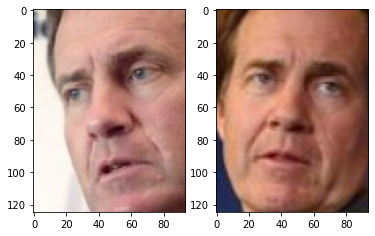

In [31]:
# Testing
# index = 3
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [ ]:
a = next(iter(LOADER))

In [ ]:
a.shape

torch.Size([10, 2, 125, 94, 3])

In [ ]:
model = model.cuda()

In [ ]:
!nvidia-smi

Tue Feb  9 13:19:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    74W / 149W |  11348MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


In [65]:
# Saving the state_dict of Model
PATH = '/content/drive/MyDrive/Colab Notebooks/siamese'

In [66]:
# torch.save(model.state_dict(), PATH)

In [ ]:
# ColabCode(port=100, password='12345')

## .

In [ ]:
!pip install torchviz

     |████████████████████████████████| 51kB 7.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=ec58767d618243e986be401fd4ad7f2f847e329e53c26d5a9e189caa732dbc32
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


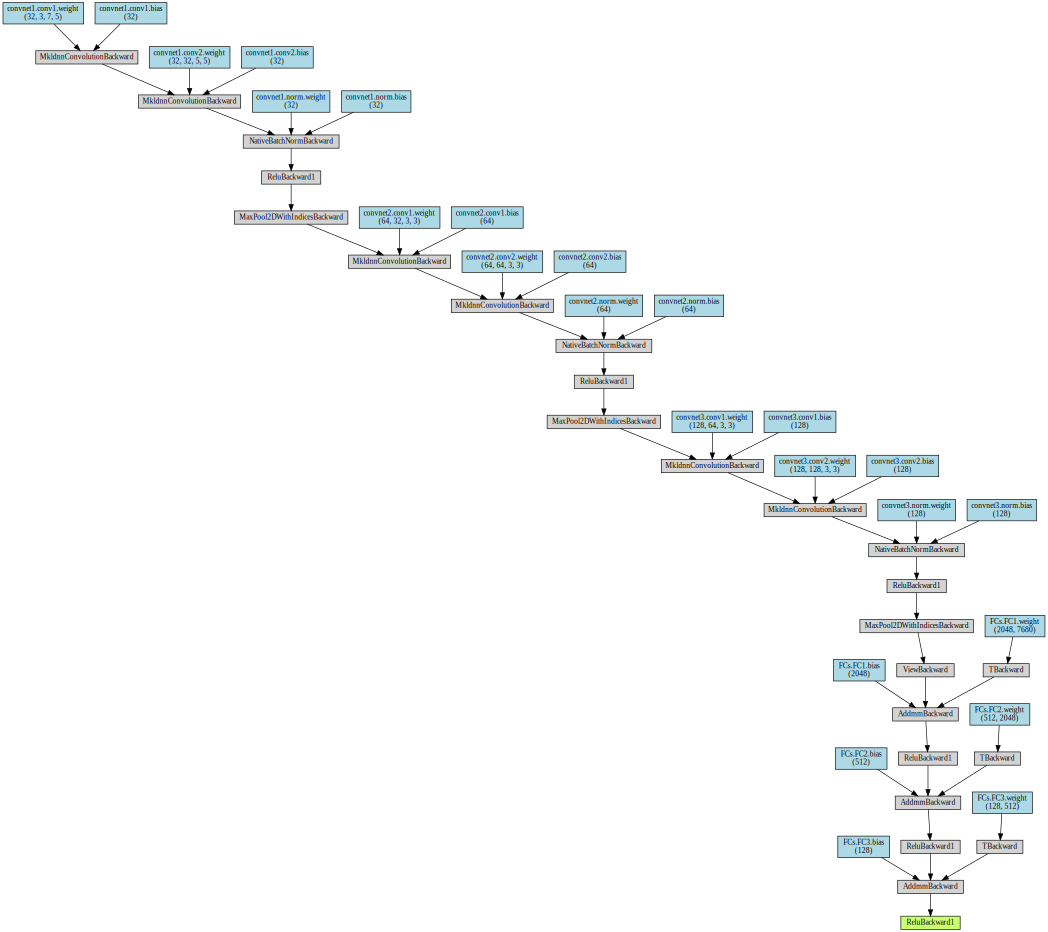

In [ ]:
from torchviz import make_dot

x = torch.randn(10,3,125,94)

make_dot(model(x), params=dict(model.named_parameters()))   

# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb

In [ ]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-p_6ry_vw
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-p_6ry_vw
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19771 sha256=6e617219ef97172c7c0ebabb961e1921e232a97f2ff82f92e7c6fa61d14bb0d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1mfd7y6p/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


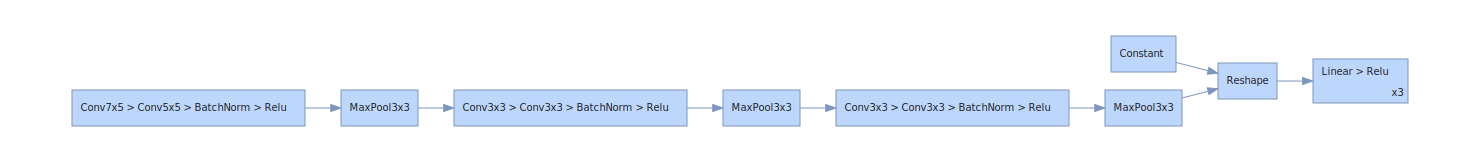

In [ ]:
import hiddenlayer as hl

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([10,3,125,94]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

#ref : https://github.com/waleedka/hiddenlayer/blob/master/demos/pytorch_graph.ipynb

## .

# TensorFlow

In [ ]:
import tensorflow as tf